<h1> ANALYSIS OF FUNDAMENTAL DATA USING ARIMA  </h1>

In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
sys.path.append("../writer")
sys.path.append("../metricas")
import metricas
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
import math
import transformations
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
import transformationsDataframes
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import norm
import math
from datetime import timedelta
import numpy as np
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import configparser
config = configparser.ConfigParser()
config.read('../../config.properties')
log_dir_excepciones = "../../"+config.get('LOGS_DIR', 'excepciones')
import writer

<h2>Configurable options:</h2>

In [2]:
precios=True
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
tamMinimo=50
column="netIncome"
column2="Adjusted_close"
tam_train=0.8
periodicidad=4
nivel_confianza=0.1
max_lag=5
ponderaciones=[0.6,0.4]
transformar=False
periodoIndice="3M"
if precios:
    periodoIndice="M"
    periodicidad=12
    
    

In [3]:
def contrasteCorrelacionResiduos(serie,diferenciacion,nivel_confianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivel_confianza/2)
    a= abs(serie)/desv<nivel

    return a

class Modelo:
    def __init__(self,modelo,modeloExtendido,significacionP=None,significacionQ=None,significacionPEst=None,significacionQEst=None):
        self.modelo=modelo
        self.modeloExtendido=modeloExtendido
        self.errorTrain=modelo.mse
        self.errorTest=modeloExtendido.mse
        self.aicTrain=modelo.aic
        self.aicTest=modeloExtendido.aic
        self.aicTotal=ponderaciones[0]*self.aicTrain+ponderaciones[1]*self.aicTest
        self.errorTotal=ponderaciones[0]+self.errorTrain*ponderaciones[1]*self.errorTest
        self.significacionP=significacionP
        self.significacionQ=significacionQ
        self.significacionPEst=significacionPEst
        self.significacionQEst=significacionQEst
def crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=None,diferenciacion=0,diferenciacionSeason=0,periodo=periodicidad):
    modelo=None
    notSeasonalTrend="c"
    seasonalTrend="c"
    if diferenciacion>0:
        notSeasonalTrend="t"
    if diferenciacionSeason>0:
        seasonalTrend="t"
        if ordenesSeason is None:
            ordenesSeason=(0,0)
        
    if  ordenes is not None:
        ordenes=(ordenes[0],diferenciacion,ordenes[1])
    if  ordenes is not None and ordenesSeason is not None:
        ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if ordenesSeason is not None:
           ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if  ordenes is not None and ordenesSeason is not None:   
        s="c"
        if notSeasonalTrend=="t" or  seasonalTrend=="t":
            s="t"
       
        modelo=ARIMA(endog=serie_train,order=ordenes,seasonal_order=ordenesSeason)
    elif ordenes is not None:
        modelo=ARIMA(endog=serie_train,order=ordenes,trend=notSeasonalTrend)
    elif ordenesSeason is not None:
        modelo=ARIMA(endog=serie_train,seasonal_order=ordenesSeason,trend= seasonalTrend)
    if modelo is not None:    
        
        adj=modelo.fit()
        adj2=adj.extend(serie_test.to_numpy())
        
        return adj,adj2

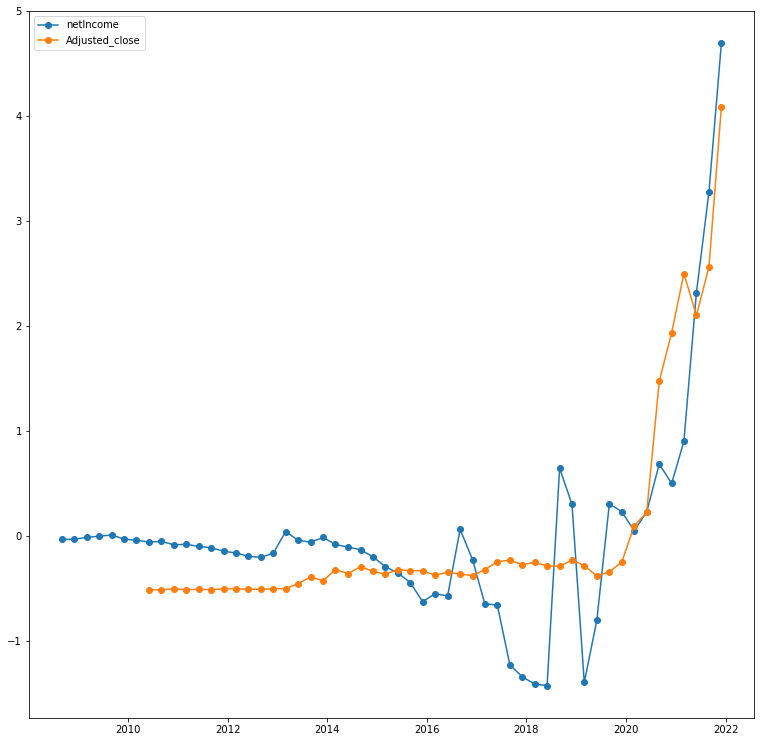

In [4]:
exchange="US"
stock="TSLA"
bd=bdStocks.getData()
data=bd.getDataByStock("fundamental",exchange,stock,bd=True,columnas=[column])
data2=bd.getDataByStock("precios",exchange,stock,bd=True,columnas=[column2])
data2= transformationsDataframes.pasarAMensual(data2)
data=transformationsDataframes.pasarAtrimestres(data)
data3=data.join(data2).fillna(method="ffill")
data3=(data3-data3.mean())/data3.std()
nas=0
nas+=int(data.isna().sum())
fig=plt.figure(figsize=(13,13))
plt.plot(data3.index,data3[column],label=column,marker="o")
plt.plot(data3.index,data3[column2],marker="o",label=column2)
plt.legend()

In [5]:
if precios==True:
    data=data2
    column=column2
data.tail()

,Adjusted_close
fecha,
2021-12-01,1095.00
2022-01-01,1199.78
2022-02-01,931.25
2022-03-01,864.37
2022-04-01,1084.59


In [6]:

all_days = pd.date_range(data.index[0],\
                        data.index[-1],freq="3M",normalize=True)
all_days 
all_days=all_days.map(lambda x:x.replace(day=1))

a=data.index[-1]
b=data.iloc[-1]
data=data.reindex(all_days)
if a!=data.index[-1]:
    data.loc[a]=b
print(all_days)
print(data.tail())

DatetimeIndex(['2010-06-01', '2010-09-01', '2010-12-01', '2011-03-01',
               '2011-06-01', '2011-09-01', '2011-12-01', '2012-03-01',
               '2012-06-01', '2012-09-01', '2012-12-01', '2013-03-01',
               '2013-06-01', '2013-09-01', '2013-12-01', '2014-03-01',
               '2014-06-01', '2014-09-01', '2014-12-01', '2015-03-01',
               '2015-06-01', '2015-09-01', '2015-12-01', '2016-03-01',
               '2016-06-01', '2016-09-01', '2016-12-01', '2017-03-01',
               '2017-06-01', '2017-09-01', '2017-12-01', '2018-03-01',
               '2018-06-01', '2018-09-01', '2018-12-01', '2019-03-01',
               '2019-06-01', '2019-09-01', '2019-12-01', '2020-03-01',
               '2020-06-01', '2020-09-01', '2020-12-01', '2021-03-01',
               '2021-06-01', '2021-09-01', '2021-12-01', '2022-03-01'],
              dtype='datetime64[ns]', freq=None)
            Adjusted_close
2021-06-01          623.90
2021-09-01          734.09
2021-12-01       

In [31]:
transformar=bool(input())
if transformar:
    minimo=np.min(data)[0]
    if minimo<0:
        print(minimo)
        data=data-minimo*2
    boxcox=transformations.boxcox
    data1=(data).applymap(lambda x:(boxcox(0,x)))
    graficos.linearplot(data1,stock+" "+column,False,column)
    graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
    print(minimo)
else:
    data1=data.copy()
data1=transformationsDataframes.pasarAtrimestres(data1)
all_days = pd.date_range(data1.index[0], data1.index[-1]+timedelta(days=40),freq=periodoIndice,normalize=True)
all_days=all_days.map(lambda x:x.replace(day=1))
nas+=len(all_days)-len(data1.index)
data1=data1.reindex(all_days)
serie=data1[column].fillna(method="ffill").dropna()
tam=len(serie)
lim_train=int(tam*tam_train)
serie_train=serie[:lim_train]
serie_test=serie[lim_train:]
all_days

DatetimeIndex(['2010-06-01', '2010-07-01', '2010-08-01', '2010-09-01',
               '2010-10-01', '2010-11-01', '2010-12-01', '2011-01-01',
               '2011-02-01', '2011-03-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', length=142, freq=None)

In [32]:
estacional=True
adf=adfuller(serie_train)
adf
posibleEstacionaridad=False
diferenciacion=0
diferenciacionEstacional=0
if adf[1]>nivel_confianza:
    posibleEstacionaridad=True

if posibleEstacionaridad and estacional:
    serie1=pd.Series(serie_train).diff(periodicidad).dropna()
    adf1=adfuller(serie1)
if posibleEstacionaridad:
    serie2=pd.Series(serie_train).diff(1).dropna()
    adf2=adfuller(serie2)

if posibleEstacionaridad and estacional:
    print(adf1,adf2)
    niveles=[0.0001,0.001,0.01,0.05,0.1]
    for idx,nivel in enumerate(niveles[1:]):
        if adf1[1]<nivel:
            diferenciacionEstacional=1
            break
        elif adf2[1]<niveles[idx]:
            diferenciacion=1
            break
    if diferenciacion==0 and diferenciacionEstacional==0:
            serie3=pd.Series(serie1).diff(1).dropna()
            adf3=adfuller(serie3)

            if adf3[0]<adf3[4]["10%"]:
                diferenciacionEstacional=1
                diferenciacion=1
            else:
                serie_train=None
                print("None")
print(diferenciacion, diferenciacionEstacional)   

(-2.539743613512953, 0.10610123691616064, 0, 100, {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}, 616.4829354699666) (-7.486094251584357, 4.6349317037600425e-11, 2, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 632.2853764018279)
1 0


In [33]:
#ver si hay que diferenciar la serie
#en adfuller la nula es que hay raiz unitaria
diferenciacion=1
diferenciacionEstacional=0
estacional=True
paramFuller=5
adf=adfuller(serie_train.diff(1).dropna())
#adf=adfuller(serie_train.diff(1).dropna())
#adf=adfuller(serie_train.diff(periodicidad).dropna())
adf


(-7.486094251584357,
 4.6349317037600425e-11,
 2,
 109,
 {'1%': -3.49181775886872,
  '5%': -2.8884437992971588,
  '10%': -2.5811201893779985},
 632.2853764018279)

hay diferenciacion
111
0.0949157995752499
[ True False False  True False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False] [ True False False  True False False False False False False False False
 False False False False False False False False False False False False
  True False False  True False False  True False False False False False
 False False]
1.2815515655446004


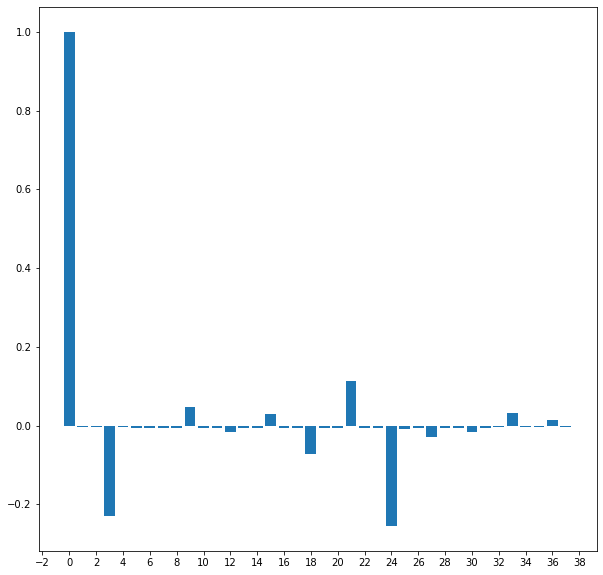

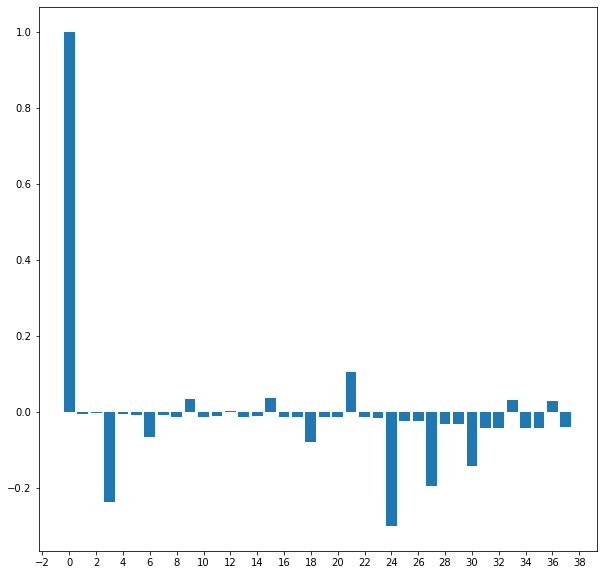

In [34]:
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
serie1=serie_train.copy()
if diferenciacion and  diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad).diff(1)
elif diferenciacion:
    print("hay diferenciacion")
    serie1=serie_train.diff(1)
elif diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad)
serie1=serie1.dropna() 
corr=acf(serie1,nlags=int(len(serie1)/3))
pcorr=pacf(serie1,nlags=int(len(serie1)/3))
nivel=norm.ppf(0.90)
def devolverEstadisticos(corr,pcorr,diferenciacion,serie):
    T=len(serie)-diferenciacion
    print(T)
    varSerie=1/T
    desv=math.sqrt(varSerie)
    print(desv)
    return abs(corr)/desv,abs(pcorr)/desv
estCorr,estPcorr=(devolverEstadisticos(corr,pcorr,diferenciacion,serie1))
print(estCorr>nivel,estPcorr>nivel)
print(nivel)
graficos.correlograma(corr,pcorr)

In [35]:
orden=(2,2)
ordenEst=(2,2)
diferenciacionEstacional=0
diferenciacion=1
adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orden,\
        ordenesSeason=ordenEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionEstacional)

if ordenEst is None:
    ordenEst=(0,0,0)
modelo=Modelo(adj,adj2, orden[0],orden[1],ordenEst[0],ordenEst[1])
print(adj.params)

ar.L1        0.000142
ar.L2        0.000136
ma.L1       -0.000191
ma.L2       -0.000189
ar.S.L12    -0.013665
ar.S.L24    -0.279655
sigma2      29.135707
dtype: float64


In [75]:
import prophet
from prophet import Prophet
import numpy as np
serie_prophet=pd.DataFrame(serie_train)
serie_prophet["ds"]=serie_prophet.index
serie_prophet["y"]=serie_prophet["Adjusted_close"]
model = Prophet(weekly_seasonality=False, yearly_seasonality=True,seasonality_mode='multiplicative').fit(serie_prophet)

serie_prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Adjusted_close,ds,y
2010-06-01,4.7780,2010-06-01,4.7780
2010-07-01,4.7780,2010-07-01,4.7780
2010-08-01,4.7780,2010-08-01,4.7780
2010-09-01,4.0900,2010-09-01,4.0900
2010-10-01,4.0900,2010-10-01,4.0900
2010-11-01,4.0900,2010-11-01,4.0900
2010-12-01,6.8700,2010-12-01,6.8700
2011-01-01,6.8700,2011-01-01,6.8700
2011-02-01,6.8700,2011-02-01,6.8700
2011-03-01,4.7880,2011-03-01,4.7880


0.36968016340451887

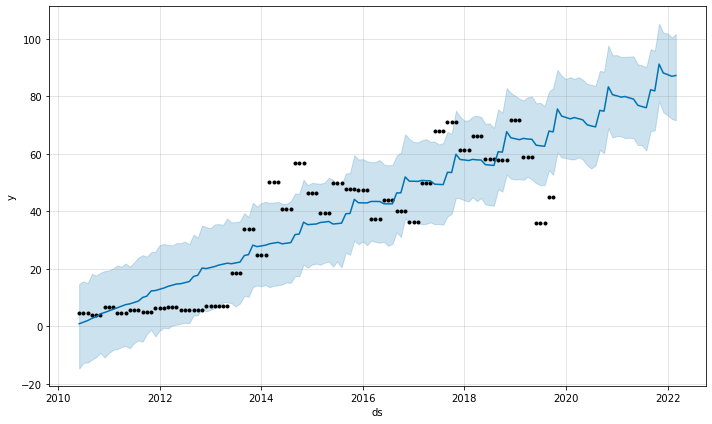

In [94]:
future = model.make_future_dataframe(periods=len(serie_test),freq = 'MS')
future.tail()
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
model.plot(forecast)
forecast=forecast.loc[forecast["ds"]<=serie_train.index[-1]]
forecast.index=serie_train.index
forecast
metricas.MAPE(serie_train,forecast.yhat)
metricas.SMAPE(serie_train,forecast.yhat)

INFO:prophet:Making 195 forecasts with cutoffs between 2011-06-15 00:00:00 and 2019-09-01 00:00:00
100%|██████████| 195/195 [10:35<00:00,  3.26s/it]


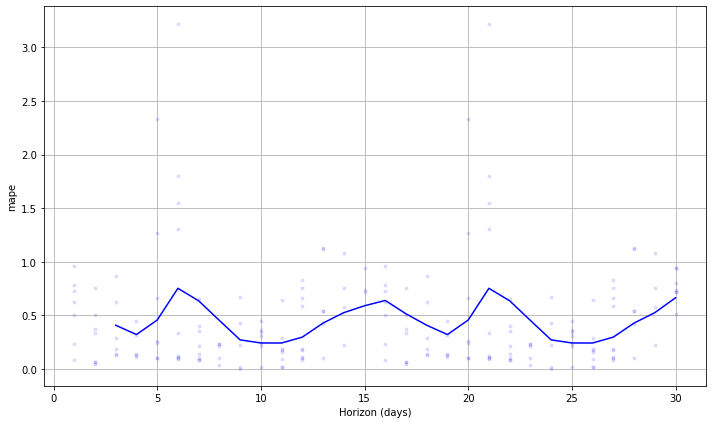

In [97]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
metric="mape"
horizon="30 days"
df_cv = cross_validation(model, horizon=horizon)
df_p = performance_metrics(df_cv)

# Mostramos los resultados del CV
plot_cross_validation_metric(df_cv, metric=metric)
plt.tight_layout()
plt.show()

5.393810173738418 100.73692129236933


1.391310552831828

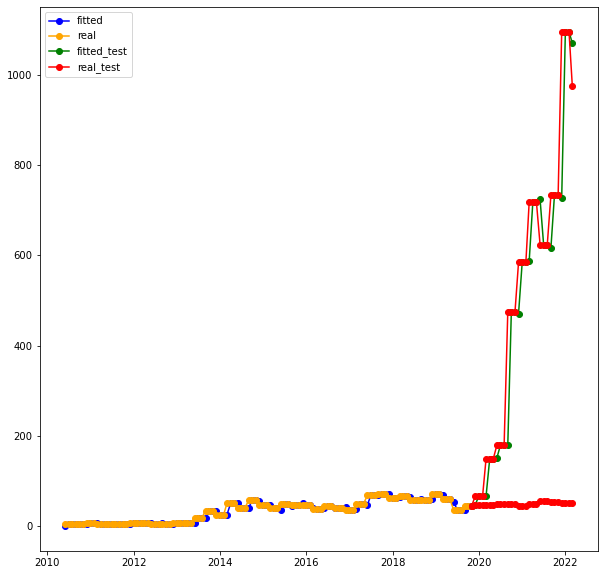

In [92]:
print(math.sqrt(adj.mse),math.sqrt(adj2.mse))
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
plt.plot(adj.fittedvalues,marker="o",c="Blue")
plt.plot(serie_train,marker="o",c="Orange")
plt.plot(adj2.fittedvalues,marker="o",c="Green")
plt.plot(serie_test,marker="o",c="Red")
plt.plot(adj.forecast(len(serie_test)),marker="o",c="Red")
plt.legend(["fitted","real","fitted_test","real_test"])
if transformar:
    for a in [serie_train,serie_test,adj.fittedvalues,adj2.fittedvalues]:
        a=a.transform(lambda x:math.exp(x))
        
metricas.SMAPE(serie_train,adj.fittedvalues)
metricas.SMAPE(serie_test,adj2.fittedvalues)
metricas.SMAPE(serie_test,adj.forecast(len(serie_test)))

4531.089712522879 ar.L1        0.000142
ar.L2        0.000136
ma.L1       -0.000191
ma.L2       -0.000189
ar.S.L12    -0.013665
ar.S.L24    -0.279655
sigma2      29.135707
dtype: float64 {'seasonal_periods': 12, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'order': (2, 1, 2), 'seasonal_order': (2, 0, 0, 12), 'k_diff': 1, 'k_seasonal_diff': 0, 'k_ar': 2, 'k_ma': 2, 'k_seasonal_ar': 24, 'k_seasonal_ma': 0, 'k_ar_params': 2, 'k_ma_params': 2, 'trend': 'n', 'k_trend': 0, 'k_exog': 0, 'mle_regression': False, 'state_regression': False} 29.093188190324064
1.2071900017904616e-09
6.035950008952308e-10
2.030382828478314e-59
[0.92 0.99 0.09 0.17 0.27 0.36 0.47 0.57 0.61 0.7  0.77 0.83 0.88 0.92
 0.93 0.95 0.97 0.98 0.99 0.99 0.99 1.  ]


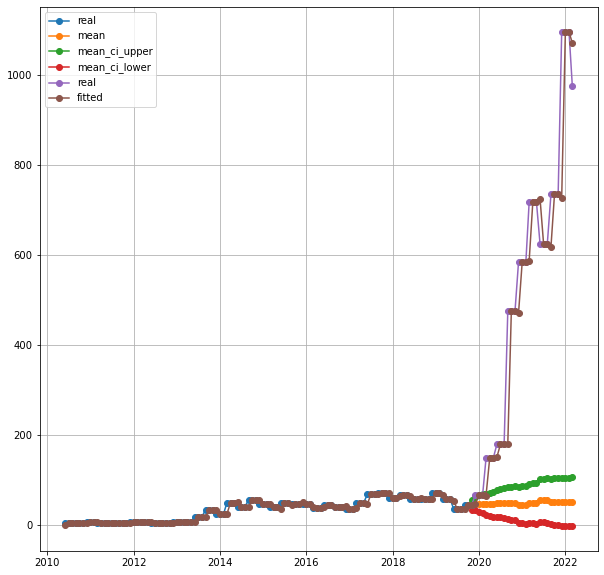

In [15]:

import matplotlib.pyplot as plt
if transformar:
    serie_train1=serie_train.map(lambda x:(math.exp(x)+2*minimo))
    serie_test1=serie_test.map(lambda x:(math.exp(x)+2*minimo))
else:
    serie_train1=serie_train
    serie_test1=serie_test
print(modelo.aicTotal,modelo.modelo.params,modelo.modelo.specification,modelo.modelo.mse)
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "two-sided")[0][1])
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "increasing")[0][1])
print(modelo.modelo.test_normality(method="jarquebera")[0][1])
u=(modelo.modelo.test_serial_correlation(method="ljungbox"))[0][1]
print(np.around(u,decimals=2))
dataframePred=modelo.modelo.get_forecast(len(serie_test1)).summary_frame()
if transformar:
    dataframePred=dataframePred.applymap(lambda x:(math.exp(x)+2*minimo))
dataframePred["real"]= serie_test1  
primero=modelo.modelo.fittedvalues
segundo=modelo.modeloExtendido.fittedvalues
if transformar:
         primero=primero.map(lambda x:(math.exp(x)+2*minimo))
         segundo=segundo.map(lambda x:(math.exp(x)+2*minimo))

graficos.plot_forecast(serie_train1,dataframePred,pd.concat([primero,segundo]))

In [16]:
data

,netIncome
2008-09-01,1409.580
2008-12-01,1409.580
2009-03-01,1419.062
2009-06-01,1424.211
2009-09-01,1430.463
2009-12-01,1410.836
2010-03-01,1405.559
2010-06-01,1396.561
2010-09-01,1400.143
2010-12-01,1383.720
